In [1]:
#import libraries
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn

In [2]:
#variables
batch_size = 64
img_size = 28
patch_size = 7
num_channels = 1
num_patches = (img_size // patch_size) ** 2
num_heads = 1
embed_dim = 16
mlp_dim = 16
transformer_units = 1

In [3]:
#Python image library (PIL) to tensor
transform = transforms.Compose(
    [transforms.ToTensor()])

In [4]:
#load dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
valset = torchvision.datasets.MNIST(root='./data', train=False,
                                        download=True, transform=transform)

100%|██████████| 9.91M/9.91M [00:00<00:00, 11.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 342kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.18MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.95MB/s]


In [6]:
#create train and val batches
train_data = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True)
val_data = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                          shuffle=False)

In [7]:
class PatchEmbedding(nn.Module):
    def __init__(self):
        super().__init__()
        self.patch_embed = nn.Conv2d(num_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.patch_embed(x)
        x = x.flatten(2)
        x = x.transpose(1,2)
        return x

In [8]:
class TransformerArchitecture(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_norm_1 = nn.LayerNorm(embed_dim)
        self.self_attention = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        self.layer_norm_2 = nn.LayerNorm(embed_dim)
        self.multi_layer_perceptron = nn.Sequential(
            nn.Linear(embed_dim, mlp_dim),
            nn.GELU(),
            nn.Linear(mlp_dim, embed_dim)
        )

    def forward(self, x):
        residual_1 = x
        attention_output = self.self_attention(self.layer_norm_1(x),self.layer_norm_1(x),self.layer_norm_1(x))[0]
        x = attention_output + residual_1
        residual_2 = x
        mlp_output = self.multi_layer_perceptron(self.layer_norm_2(x))
        x = mlp_output + residual_2
        return x


In [9]:
class VisionTransformer(nn.Module):
    def __init__(self):
        super().__init__()
        self.patch_embedding = PatchEmbedding()
        self.cls_token = nn.Parameter(torch.randn(1,1,embed_dim))
        self.pos_embed = nn.Parameter(torch.randn(1, (img_size // patch_size) ** 2 + 1, embed_dim))
        self.transformer_layers = nn.Sequential(*[TransformerArchitecture() for _ in range(transformer_units)])

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, 10)
        )

    def forward(self,x):
        x = self.patch_embedding(x)
        B = x.size(0)

        cls_tokens = self.cls_token.expand(B , -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        x = self.transformer_layers(x)
        x = x[:,0]
        x = self.mlp_head(x)
        return x

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VisionTransformer().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [11]:
for epoch in range(5):
    model.train()
    total_loss = 0
    correct_epoch = 0
    total_epoch = 0
    print(f"\nEpoch {epoch+1}")

    for batch_idx, (images, labels) in enumerate(train_data):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss+=loss.item()
        preds = outputs.argmax(dim=1)

        correct = (preds == labels).sum().item()
        accuracy = 100.0 * correct / labels.size(0)

        correct_epoch += correct
        total_epoch += labels.size(0)

        if batch_idx % 100 == 0:
            print(f"  Batch {batch_idx+1:3d}: Loss = {loss.item():.4f}, Accuracy = {accuracy:.2f}%")

    epoch_acc = 100.0 * correct_epoch / total_epoch
    print(f"==> Epoch {epoch+1} Summary: Total Loss = {total_loss:.4f}, Accuracy = {epoch_acc:.2f}%")


Epoch 1
  Batch   1: Loss = 2.4958, Accuracy = 9.38%
  Batch 101: Loss = 1.2618, Accuracy = 51.56%
  Batch 201: Loss = 0.9814, Accuracy = 62.50%
  Batch 301: Loss = 0.7563, Accuracy = 73.44%
  Batch 401: Loss = 0.9335, Accuracy = 70.31%
  Batch 501: Loss = 0.6970, Accuracy = 76.56%
  Batch 601: Loss = 0.8725, Accuracy = 68.75%
  Batch 701: Loss = 0.6465, Accuracy = 78.12%
  Batch 801: Loss = 0.5627, Accuracy = 78.12%
  Batch 901: Loss = 0.5662, Accuracy = 79.69%
==> Epoch 1 Summary: Total Loss = 853.7784, Accuracy = 68.66%

Epoch 2
  Batch   1: Loss = 0.5974, Accuracy = 78.12%
  Batch 101: Loss = 0.6522, Accuracy = 76.56%
  Batch 201: Loss = 0.7323, Accuracy = 78.12%
  Batch 301: Loss = 0.4323, Accuracy = 84.38%
  Batch 401: Loss = 0.7547, Accuracy = 81.25%
  Batch 501: Loss = 0.3807, Accuracy = 85.94%
  Batch 601: Loss = 0.5362, Accuracy = 82.81%
  Batch 701: Loss = 0.5681, Accuracy = 81.25%
  Batch 801: Loss = 0.3301, Accuracy = 89.06%
  Batch 901: Loss = 0.7454, Accuracy = 81.25%
=

In [12]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_data:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

test_acc = 100.0 * correct / total
print(f"\n==> Val Accuracy: {test_acc:.2f}%")



==> Val Accuracy: 86.50%


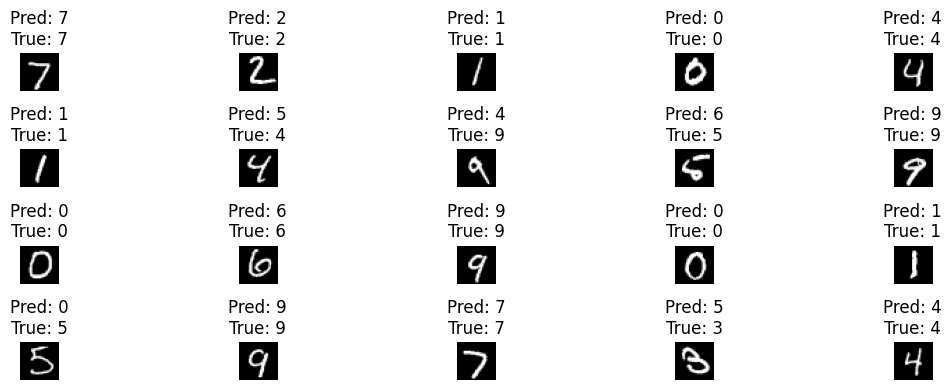

In [13]:
model.eval()
images, labels = next(iter(val_data))
images, labels = images.to(device), labels.to(device)

with torch.no_grad():
    outputs = model(images)
    preds = outputs.argmax(dim=1)

# Plot 10 test images with predictions
plt.figure(figsize=(12, 4))
for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title(f"Pred: {preds[i].item()}\nTrue: {labels[i].item()}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [14]:
# Get one batch from the validation data
images, labels = next(iter(val_data))

# Print the shape of the images tensor
print("Shape of images in a batch:", images.shape)
patch_embed = nn.Conv2d(num_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
embedded_data = patch_embed(images)
embedded_data = embedded_data.flatten(2)
embedded_data = embedded_data.transpose(1,2)
print("Shape of embedded data:", embedded_data.shape)
print(torch.randn(1,1,embed_dim).shape)

# You can also print the shape of the labels tensor if you'd like
# print("Shape of labels in a batch:", labels.shape)

Shape of images in a batch: torch.Size([64, 1, 28, 28])
Shape of embedded data: torch.Size([64, 16, 16])
torch.Size([1, 1, 16])
